In [49]:
#assumptions that will break if we use MCTS for play traces in this code
#1. Turn wont be either 0 or 1
#2. Cant just copy the final two rows to extend round number to maxNoOfRounds

In [75]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [76]:
#parameters for round robin tournament
NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
games_per_matchup = 100
self_play = False
agents = ['MCTS_A_Budget_1000', 'MCTS_B_Budget_1000']

NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup

In [77]:
data  = pd.read_csv("data/featureslogfile_Budget_2000_Budget_2000_GPM_100_NoSelfPlay.txt", sep = '\t')
print(data)
print(data.columns)

       GameID  Player  Round  Turn  CurrentScore  SCORE  SCORE_ADV  ORDINAL  \
0         2.0     0.0    0.0   0.0           3.0   0.06       0.00      0.5   
1         2.0     1.0    0.0   0.0           3.0   0.06       0.00      0.5   
2         2.0     0.0    0.0   1.0           3.0   0.06       0.00      0.5   
3         2.0     1.0    0.0   1.0           3.0   0.06       0.00      0.5   
4         2.0     0.0    1.0   0.0           3.0   0.06       0.00      0.5   
...       ...     ...    ...   ...           ...    ...        ...      ...   
23233   201.0     1.0   21.0   1.0          49.0   0.98      -0.12      1.0   
23234   201.0     0.0   22.0   0.0          53.0   1.06       0.16      0.5   
23235   201.0     1.0   22.0   0.0          49.0   0.98      -0.16      1.0   
23236   201.0     0.0   22.0   1.0          53.0   1.06      -0.16      1.0   
23237   201.0     1.0   22.0   1.0          57.0   1.14       0.16      0.5   

       OUR_TURN  HAS_WON  ...  MINE  SENTRY  WITCH 

In [78]:
#label all games with corresponding agent names

#first generate match-ups
matchups = []
if self_play:
    for agent1 in agents:
        for agent2 in agents:
            matchups.append((agent1, agent2))
else:
    matchups = list(itertools.permutations(agents, 2))
    
#function to map gameID to match-up
def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
    game_group = int((game_id - min_game_id)/no_games_per_matchup)
    matchup = matchup_list[game_group]
    agent1, agent2 = matchup
    if player_no == 0:
        return agent1
    else:
        return agent2
        
#add agent names to data set
min_GameID = data['GameID'].min()
data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [79]:
#check for agmes where the round number suddenly decreases (Bug in TAG? - nope this was
#from me stopping execution and restarting and the code appending results to an existing file)
NoGamesDropped = 0 
for game in data['GameID'].unique():
    round_data = data[data['GameID'] == game]['Round']
    round_delta = round_data - round_data.shift(1)
    if round_delta.min() < 0:
        NoGamesDropped += 1
        print("Issue with GameID: " + str(game))

In [137]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types = card_types_SD 
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [103]:
#we seem to have an issue with some cards having their number reduced, which shouldn't happen in a BMWG vs DW set-up
#for card in card_types_BigMoneyWithGardens_vs_DoubleWitch:
#    for game in data['GameID'].unique():
#        for player in data['Player'].unique():
#            card_evol = data[(data['GameID'] == game) & (data['Player'] == player) & (data['Turn'] == 1)][card]
#            card_delta = card_evol - card_evol.shift(1)
#            if card_delta.min() < 0:
#                print("Issue with " + str(card) + " in game " + str(game) + " with player " + str(player))
                
#problem_trace = data[(data['GameID'] == 27) & (data['Player'] == 1)]['WITCH']
#print(problem_trace)

In [128]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
print(data['Turn'].unique())
data = data[data['Turn'] == 1]

[1.]


In [130]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

                AgentName  Player  GameID  Win  FinalScore  Round  ARTISAN  \
2      MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    0.0      0.0   
3      MCTS_B_Budget_1000     1.0     2.0  0.0        46.0    0.0      0.0   
6      MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    1.0      0.0   
7      MCTS_B_Budget_1000     1.0     2.0  0.0        46.0    1.0      0.0   
10     MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    2.0      0.0   
...                   ...     ...     ...  ...         ...    ...      ...   
23229  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   20.0      0.0   
23232  MCTS_B_Budget_1000     0.0   201.0  0.0        53.0   21.0      0.0   
23233  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   21.0      0.0   
23236  MCTS_B_Budget_1000     0.0   201.0  0.0        53.0   22.0      0.0   
23237  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   22.0      0.0   

       BANDIT  BUREAUCRAT  CHAPEL  ...  THRONE_ROOM  WITCH  WOR

In [131]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

62


In [132]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [133]:
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*(NoOfGames-NoGamesDropped)))
print("Expected no of cols: " + str(len(card_types)+6))
print(extended_traces.shape)

                AgentName  Player  GameID  Win  FinalScore  Round  ARTISAN  \
0      MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    0.0      0.0   
1      MCTS_B_Budget_1000     1.0     2.0  0.0        46.0    0.0      0.0   
2      MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    1.0      0.0   
3      MCTS_B_Budget_1000     1.0     2.0  0.0        46.0    1.0      0.0   
4      MCTS_A_Budget_1000     0.0     2.0  1.0        79.0    2.0      0.0   
...                   ...     ...     ...  ...         ...    ...      ...   
24795  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   59.0      0.0   
24796  MCTS_B_Budget_1000     0.0   201.0  0.0        53.0   60.0      0.0   
24797  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   60.0      0.0   
24798  MCTS_B_Budget_1000     0.0   201.0  0.0        53.0   61.0      0.0   
24799  MCTS_A_Budget_1000     1.0   201.0  1.0        57.0   61.0      0.0   

       BANDIT  BUREAUCRAT  CHAPEL  ...  THRONE_ROOM  WITCH  WOR

In [173]:
#next we need to flatten this dataframe so that each trace is a single row.
#We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names

#first create dataframe consisting of only non card type data types that are round 
#independent
non_card_data_round_indep = extended_traces[index_cols + non_card_types_round_indep_cols].drop_duplicates()

#next need to Group by Player and GameID and then flatten card data by round
traces_tmp = extended_traces[index_cols + card_types]
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = index_cols + cols

#next we add back in the round independent data
extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)
                                 
#finally we also add the name of the agent of the opponent 
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)  

print(extended_traces_flat)

     Player  GameID           AgentName  Win  FinalScore  ARTISAN_R0  \
0       0.0     2.0  MCTS_A_Budget_1000  1.0        79.0         0.0   
1       1.0     2.0  MCTS_B_Budget_1000  0.0        46.0         0.0   
2       0.0     3.0  MCTS_A_Budget_1000  0.0        49.0         0.0   
3       1.0     3.0  MCTS_B_Budget_1000  1.0        71.0         0.0   
4       0.0     4.0  MCTS_A_Budget_1000  0.0        54.0         0.0   
..      ...     ...                 ...  ...         ...         ...   
395     1.0   199.0  MCTS_A_Budget_1000  0.0        41.0         0.0   
396     0.0   200.0  MCTS_B_Budget_1000  1.0        64.0         0.0   
397     1.0   200.0  MCTS_A_Budget_1000  0.0        50.0         0.0   
398     0.0   201.0  MCTS_B_Budget_1000  0.0        53.0         0.0   
399     1.0   201.0  MCTS_A_Budget_1000  1.0        57.0         0.0   

     BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  ...  WORKSHOP_R61  \
0          0.0            0.0        0.0          0.0  ... 

In [174]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

            AgentName   AgentNameOpponent  Win_avg  FinalScore_avg  \
0  MCTS_A_Budget_1000  MCTS_B_Budget_1000      0.0            52.0   
1  MCTS_B_Budget_1000  MCTS_A_Budget_1000      1.0            54.0   

   ARTISAN_R0_avg  BANDIT_R0_avg  BUREAUCRAT_R0_avg  CHAPEL_R0_avg  \
0             0.0            0.0                0.0            0.0   
1             0.0            0.0                0.0            0.0   

   FESTIVAL_R0_avg  GARDENS_R0_avg  ...  THRONE_ROOM_R61_avg  WITCH_R61_avg  \
0              0.0             0.0  ...                  0.0            0.0   
1              0.0             0.0  ...                  0.0            0.0   

   WORKSHOP_R61_avg  CURSE_R61_avg  PROVINCE_R61_avg  DUCHY_R61_avg  \
0               2.0            1.0               3.0            4.0   
1               2.0            1.0               3.0            4.0   

   ESTATE_R61_avg  GOLD_R61_avg  SILVER_R61_avg  COPPER_R61_avg  
0             6.0           4.0             7.0            1

In [176]:
#prepare data for kmeans
tmp =  index_cols + non_card_types_round_indep_cols
tmp  = tmp + ['Opponent','AgentNameOpponent']
trace_X = extended_traces_flat.drop(tmp, axis = 1)
print(trace_X)

     ARTISAN_R0  BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  GARDENS_R0  \
0           0.0        0.0            0.0        0.0          0.0         0.0   
1           0.0        0.0            0.0        0.0          0.0         0.0   
2           0.0        1.0            0.0        0.0          0.0         0.0   
3           0.0        1.0            0.0        0.0          0.0         0.0   
4           0.0        0.0            0.0        0.0          0.0         0.0   
..          ...        ...            ...        ...          ...         ...   
395         0.0        0.0            0.0        0.0          0.0         0.0   
396         0.0        0.0            0.0        0.0          0.0         0.0   
397         0.0        0.0            0.0        0.0          0.0         0.0   
398         0.0        0.0            0.0        0.0          0.0         0.0   
399         0.0        0.0            0.0        0.0          0.0         0.0   

     SENTRY_R0  THRONE_ROOM

[1.         0.65086642 0.57364747 0.52141768 0.48558356 0.45881112
 0.44043524 0.41877257 0.40382629 0.39090129 0.37939219 0.367418
 0.35562181 0.35129957 0.34028263 0.33491645 0.328186   0.32299294
 0.31816171 0.31267745 0.30557241 0.30221856 0.29791357 0.29386691]


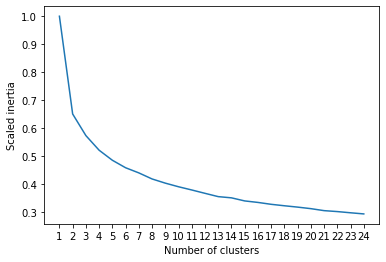

In [177]:
#inertia and elbow method
range_n_clusters = range(1, 25, 1)
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

For n_clusters = 2 The average silhouette_score is : 0.31830514557130923
For n_clusters = 3 The average silhouette_score is : 0.26435331091230757
For n_clusters = 4 The average silhouette_score is : 0.1545385602618024
For n_clusters = 5 The average silhouette_score is : 0.15015688820857612
For n_clusters = 6 The average silhouette_score is : 0.14877274679789704


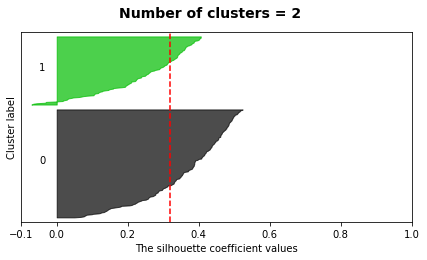

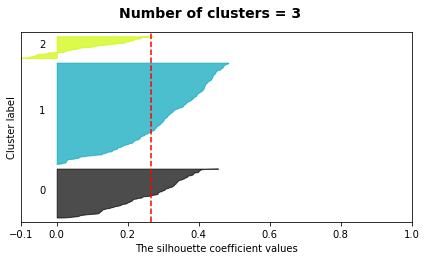

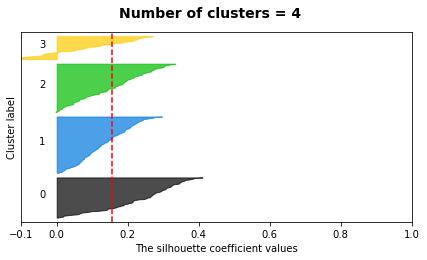

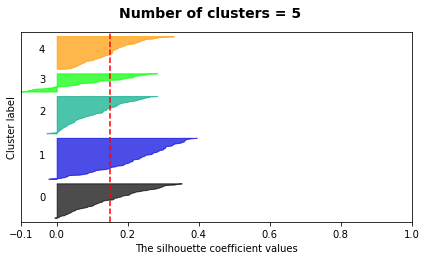

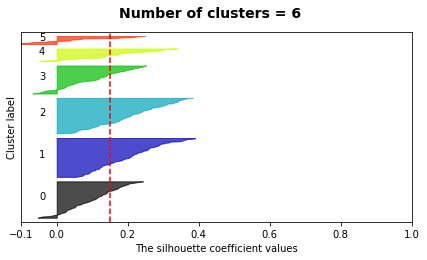

Text(0, 0.5, 'Silhouette Average')

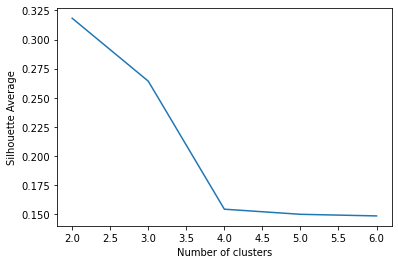

In [193]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [194]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces 
num_clusters = len(matchups)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [195]:
#add kmeans cluster classifications of traces to dataframe 
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName           AgentNameOpponent   ClusterID
MCTS_A_Budget_1000  MCTS_B_Budget_1000  0            116
                                        1             84
MCTS_B_Budget_1000  MCTS_A_Budget_1000  0            129
                                        1             71
dtype: int64


In [183]:
def deck_evol_comparison(trace1, trace2, tag1, tag2, cardTypes, maxRounds, label1 = 'Trace1', label2 = 'Trace2'):
    #look at evolution of number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 4
    noOfSubplotsInYDirection = 5
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= 17:
                axs[1,4].set_visible(False)
                axs[2,4].set_visible(False)
                axs[3,4].set_visible(False)
                break
            cardType = cardTypes[cardIndex]
            card_col_1 = [cardType + "_R" + str(r) + tag1 for r in range(0,maxRounds)]
            card_col_2 = [cardType + "_R" + str(r) + tag2 for r in range(0,maxRounds)]
            axs[i,j].plot(range(0,maxRounds), trace1[card_col_1].iloc[0], label = label1)
            axs[i,j].plot(range(0,maxRounds), trace2[card_col_2].iloc[0], label = label2)
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            card_max = int(trace1[card_col_1].iloc[0].max())
            #pdb.set_trace()
            axs[i,j].set_ylim((0,card_max+2))
            axs[i,j].set_xticks(ticks = range(0, maxRounds,5))
            fig.tight_layout() 
    #add overal legend to figure
    axs[0,4].legend(loc = (1.2,0.7))

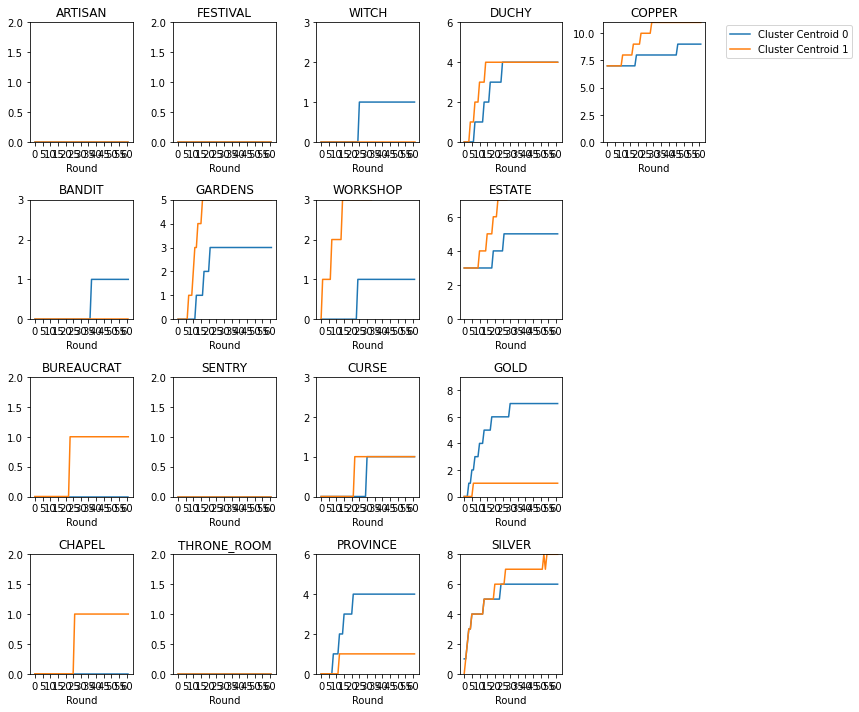

In [196]:
#compare centroids
deck_evol_comparison(cluster0centre, cluster1centre, "", "", card_types, maxNoOfRounds, 'Cluster Centroid 0', 
                     'Cluster Centroid 1')

In [189]:
print(extended_traces_flat)

     Player  GameID           AgentName  Win  FinalScore  ARTISAN_R0  \
0       0.0     2.0  MCTS_A_Budget_1000  1.0        79.0         0.0   
1       1.0     2.0  MCTS_B_Budget_1000  0.0        46.0         0.0   
2       0.0     3.0  MCTS_A_Budget_1000  0.0        49.0         0.0   
3       1.0     3.0  MCTS_B_Budget_1000  1.0        71.0         0.0   
4       0.0     4.0  MCTS_A_Budget_1000  0.0        54.0         0.0   
..      ...     ...                 ...  ...         ...         ...   
395     1.0   199.0  MCTS_A_Budget_1000  0.0        41.0         0.0   
396     0.0   200.0  MCTS_B_Budget_1000  1.0        64.0         0.0   
397     1.0   200.0  MCTS_A_Budget_1000  0.0        50.0         0.0   
398     0.0   201.0  MCTS_B_Budget_1000  0.0        53.0         0.0   
399     1.0   201.0  MCTS_A_Budget_1000  1.0        57.0         0.0   

     BANDIT_R0  BUREAUCRAT_R0  CHAPEL_R0  FESTIVAL_R0  ...  CURSE_R61  \
0          0.0            0.0        0.0          0.0  ...    

In [200]:
#look a frequency of win rate and average final score by cluster
win_score = extended_traces_flat[['ClusterID', 'Win','FinalScore']]
means = win_score.groupby('ClusterID').mean()
print(means)


                Win  FinalScore
ClusterID                      
0          0.497959   54.600000
1          0.503226   49.916129
